# Residual amplitude modulation in Pound-Drever-Hall frequency locking
by: Josiah Sinclair

What is residual amplitude modulation (RAM) and where does it come from? This Jupyter Notebook addresses some common misconceptions and demonstrates a model for RAM. 



In [109]:
# First, let me import some useful Python packes
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy as sp
from scipy import signal as sig
from scipy.optimize import curve_fit

In [110]:
# Functions I will use. 
def FrequencyFilter(t,ydata, cutoff_frequency, center_freq):
    dt = abs(t[2]-t[1])
    df = 1.0/(abs(max(t)-min(t)))
    f_max = 1.0/dt
    f= np.arange(-f_max/2-df/2.0,f_max/2,df)
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fourier transform.
    Filter_Function = np.exp(-(2*np.pi*f-2*np.pi*center_freq)**2/(2*2*np.pi*cutoff_frequency)**2) 
    Filtered_FT = FT*Filter_Function 
    Filtered_E_T = np.fft.ifft(np.fft.ifftshift(Filtered_FT))
    return(Filtered_E_T) # Returns the frequency filtered field values

def PowerSpectrum(t,ydata):
    dt = abs(t[2]-t[1]) # Define my smallest time step.
    
    df = 1.0/(abs(max(t)-min(t))) # Define my smallest frequency step.
    f_max = 1.0/dt # Define the frequency range. 
    f = np.arange(-f_max/2-df/2,f_max/2,df)
    
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fast Fourier transform.
    PWRspectrum = np.real(np.conj(FT)*FT)/df # Find the power density spectrum (power per df)
    return(f, PWRspectrum) # This function returns the frequency values as well as the frequency spectrum.
                     
def CavityResponse(f, f_0, gamma):
           return(4*1j*(f-f_0)/gamma/2/(1+2*1j*(f-f_0)/gamma))
    
def Cavity(t,E,cavity_resonance, gamma):
    dt = abs(t[2]-t[1])
    df = 1.0/(abs(max(t)-min(t)))
    f_max = 1.0/dt
    f= np.arange(-f_max/2-df/2.0,f_max/2,df)
    FT = np.fft.fftshift(np.fft.fft(E)) # Take a Fourier transform.
    Reflected_FT = FT*CavityResponse(f, cavity_resonance, gamma)
    Reflected_E_T = np.fft.ifft(np.fft.ifftshift(Reflected_FT))
    return((Reflected_E_T)) # Returns the frequency filtered field values

# Alright, let's put everything together and define a function that takes the detuning and calculates the E_ref.
# From the reflected field, it calculates the PDH error signal. 
def PDH(f_N, cavity_detuning):
    EOMPhase1 = .5*np.sin(2*np.pi*f_EOM*t) # This is my EOM phase modulation.
    E1 = np.exp(1j*2*np.pi*f_0*t +1j*EOMPhase1) # This is my input electric field.
    E_ref1 = Cavity(t,E1,f_0-cavity_detuning, gamma) # This is my reflected field.
    ErrorSignalPreMixer1 = np.real(E_ref1*np.conjugate(E_ref1)) # This is what my reflection detector measures.
    ErrorSignalPostMixer1 = ErrorSignalPreMixer1*np.sin(2*np.pi*f_EOM*t) # Mix with LO.
    ErrorSignalLowpass1 = FrequencyFilter(t,ErrorSignalPostMixer1, f_EOM/5, 0) # Lowpass filter at F_EOM/10.
    return(ErrorSignalLowpass1) 


def PDH_RAM(f_N, cavity_detuning, a_RAM, phase_RAM):
    EOMPhase1 = .5*np.sin(2*np.pi*f_EOM*t) # This is my EOM phase modulation.
    RAM = (1 + a_RAM*np.cos(2*np.pi*f_EOM*t + phase_RAM)) # This is my RAM
    E1 = np.exp(1j*2*np.pi*f_0*t +1j*EOMPhase1)*RAM # This is my input electric field with RAM
    E_ref1 = Cavity(t,E1,f_0-cavity_detuning, gamma) # This is my reflected field.
    ErrorSignalPreMixer1 = np.real(E_ref1*np.conjugate(E_ref1)) # This is what my reflection detector measures.
    ErrorSignalPostMixer1 = ErrorSignalPreMixer1*np.sin(2*np.pi*f_EOM*t) # Mix with LO.
    ErrorSignalLowpass1 = FrequencyFilter(t,ErrorSignalPostMixer1, f_EOM/5, 0) # Lowpass filter at F_EOM/10.
    return(ErrorSignalLowpass1) 



<ipython-input-111-d095250690f9>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  PDH_error[i] = np.mean(PDH(f_N, cav_det[i]))


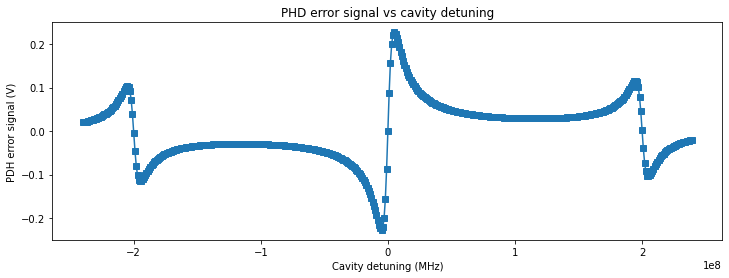

In [111]:
# Great, first, vary the detuning of our input light and reproduce the famous PDH error signal scan
dt = 1e-11
t_max = 1e-6
t = np.arange(0,t_max,dt) #Timing resolution.
f_0 = 1e9 # This laser is more of a maser.
f_EOM = 200e6 # Frequency of my EOM.
gamma = 10e6 # Cavity linewidth.
cav_det = np.arange(-24*gamma, 24*gamma,0.1*gamma) # Cavity detunings
PDH_error = 0*cav_det
for i in range(len(cav_det)):
    PDH_error[i] = np.mean(PDH(f_N, cav_det[i]))

        
plt.figure(figsize = (12,4))
plt.plot(cav_det, PDH_error, '-s')
plt.title("PHD error signal vs cavity detuning")
plt.xlabel("Cavity detuning (MHz)")
plt.ylabel("PDH error signal (V)")
plt.show()

Cool, so you can see the famous PDH error signal shape, which is the shape your error signal will take if you slowly scan your laser's frequency across resonance. 

# What RAM is not

Sometimes people talk about RAM as if it occurs simply when the two sidebands are of unequal amplitude. This actually does not cause RAM. Let's work through a brief example to show that this is the case. 

/Users/josiahsinclair/Documents/reg_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/josiahsinclair/Documents/reg_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


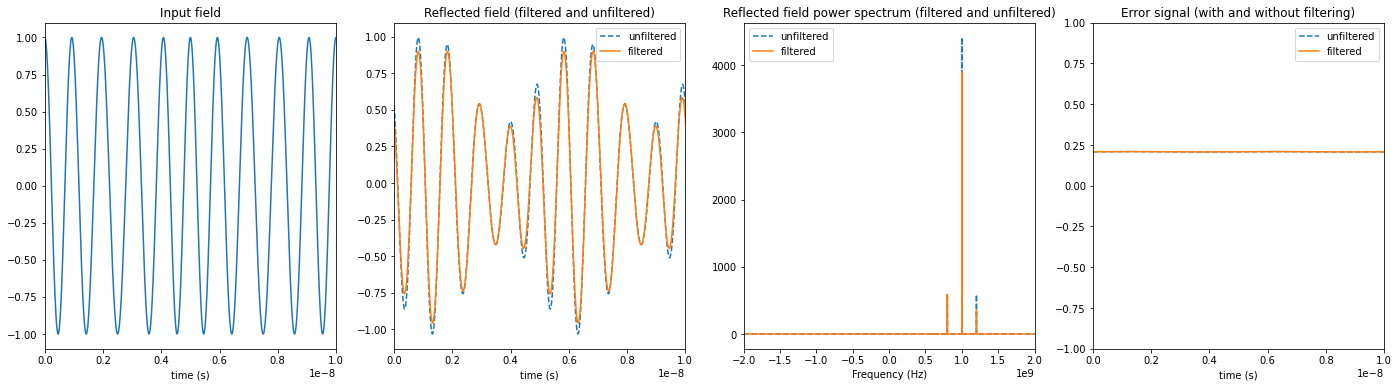

In [116]:
# To do this, I'm going to open up my PDH error signal function and look at what is happening inside. 
cavity_detuning = gamma/2
EOMPhase1 = .5*np.sin(2*np.pi*f_EOM*t) # This is my EOM phase modulation.
E1 = np.exp(1j*2*np.pi*f_0*t +1j*EOMPhase1) # This is my input electric field.
E_ref = Cavity(t,E1,f_0-cavity_detuning, gamma) # This is my reflected field.

# First, let's plot the input field
fig,axes = plt.subplots(1,4,figsize=(24,6))
axes[0].plot(t,np.real(E1))
axes[0].set_title("Input field")
axes[0].set_xlabel("time (s)")
axes[0].set_xlim(0, 10/f_0)

# Next, let's pass the input field through a frequency filter that filters one sideband more than the other. 
E_ref_filtered = FrequencyFilter(t,E_ref, f_EOM/.5, f_0-f_EOM)

# Next, let's plot the reflected field (with and without filtering)
axes[1].plot(t,np.real(E_ref), '--', label = "unfiltered")
axes[1].plot(t,np.real(E_ref_filtered), label = "filtered")
axes[1].set_title("Reflected field (filtered and unfiltered)")
axes[1].set_xlabel("time (s)")
axes[1].set_xlim(0, 10/f_0)
axes[1].legend()

# Let's take a look at the resulting power spectrum of the filtered and unfiltered fields
f, PwrSpectrumRef = PowerSpectrum(t,E_ref)
f, PwrSpectrumRefFiltered = PowerSpectrum(t,E_ref_filtered)

axes[2].plot(f,PwrSpectrumRef, '--', label = "unfiltered")
axes[2].plot(f,PwrSpectrumRefFiltered, label = "filtered")
axes[2].set_xlim(-2*f_0,2*f_0)
axes[2].set_title("Reflected field power spectrum (filtered and unfiltered)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

# Next, let's make our error signal
ErrorSignalPreMixer = np.real(E_ref*np.conjugate(E_ref)) # This is what my reflection detector measures.
ErrorSignalPostMixer = ErrorSignalPreMixer*np.sin(2*np.pi*f_EOM*t) # Mix with LO.
ErrorSignalLowpass = FrequencyFilter(t,ErrorSignalPostMixer, f_EOM/5, 0) # Lowpass filter at F_EOM/10.

ErrorSignalPreMixer_filtered = np.real(E_ref*np.conjugate(E_ref_filtered)) # Measure light
ErrorSignalPostMixer_filtered = ErrorSignalPreMixer_filtered*np.sin(2*np.pi*f_EOM*t) # Mix with LO.
ErrorSignalLowpass_filtered = FrequencyFilter(t,ErrorSignalPostMixer_filtered, f_EOM/5, 0) # lowpass at F_EOM/10.



# Let's plot the error signal in time
axes[3].plot(t,ErrorSignalLowpass_filtered, '--', label = "unfiltered")
axes[3].plot(t,ErrorSignalLowpass_filtered, label = "filtered")
axes[3].legend()
axes[3].set_title("Error signal (with and without filtering)")
axes[3].set_xlabel("time (s)")
axes[3].set_xlim(0, 10/f_0)
axes[3].set_ylim(-1,1)

plt.show()


# What RAM is

So what does cause RAM then? What does cause RAM is when the electric field amplitude is modulated at the EOM modulation frequency. 

(0.0009088662477773769-9.047287949798741e-31j)
(-0.03012786326244746+2.0162527430980052e-29j)


/Users/josiahsinclair/Documents/reg_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/josiahsinclair/Documents/reg_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


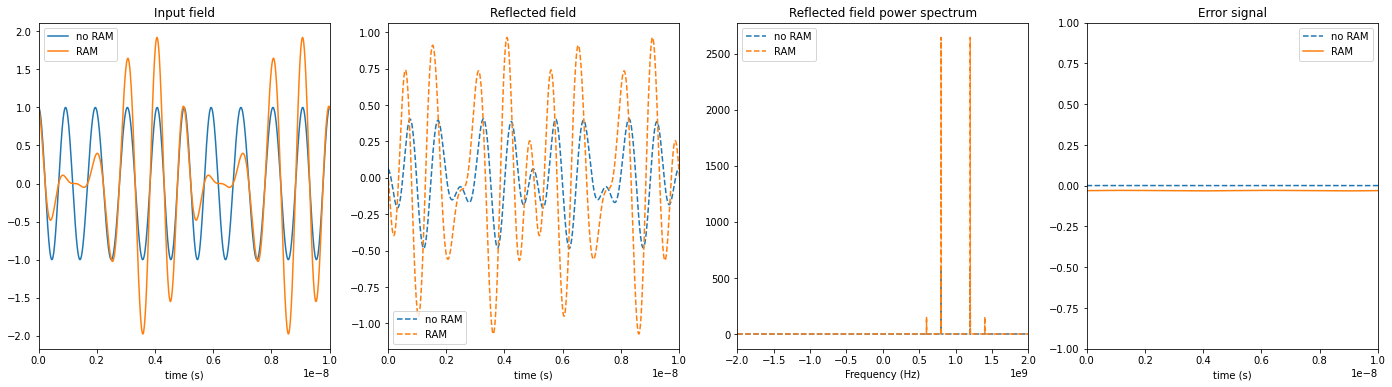

In [113]:
# Mostly same setup
cavity_detuning = 0
EOMPhase1 = .5*np.sin(2*np.pi*f_EOM*t) # This is my EOM phase modulation.
RAM = (1 + 1*np.cos(2*np.pi*f_EOM*t + np.pi/2.0))
E1 = np.exp(1j*2*np.pi*f_0*t +1j*EOMPhase1) # This is my input electric field, with no RAM 
E2 = np.exp(1j*2*np.pi*f_0*t +1j*EOMPhase1)*RAM # This is my input electric field, with RAM 

E_ref1 = Cavity(t,E1,f_0-cavity_detuning, gamma) # This is my reflected field.
E_ref2 = Cavity(t,E2,f_0-cavity_detuning, gamma) # This is my reflected field.

# First, let's plot the input field with and without RAM
fig,axes = plt.subplots(1,4,figsize=(24,6))
axes[0].plot(t,np.real(E1), label = "no RAM")
axes[0].plot(t,np.real(E2), label = "RAM")
axes[0].set_title("Input field")
axes[0].set_xlabel("time (s)")
axes[0].set_xlim(0, 10/f_0)
axes[0].legend()


# Next, let's plot the reflected field with and without RAM
axes[1].plot(t,np.real(E_ref1), '--', label = "no RAM")
axes[1].plot(t,np.real(E_ref2), '--', label = "RAM")
axes[1].set_title("Reflected field")
axes[1].set_xlabel("time (s)")
axes[1].set_xlim(0, 10/f_0)
axes[1].legend()

# Let's take a look at the resulting power spectrum of the filtered and unfiltered fields
f, PwrSpectrumRef1 = PowerSpectrum(t,E_ref1)
f, PwrSpectrumRef2 = PowerSpectrum(t,E_ref2)

axes[2].plot(f,PwrSpectrumRef1, '--', label = "no RAM")
axes[2].plot(f,PwrSpectrumRef2, '--', label = "RAM")
axes[2].set_xlim(-2*f_0,2*f_0)
axes[2].set_title("Reflected field power spectrum")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

# Next, let's make our error signal
ErrorSignalPreMixer1 = np.real(E_ref1*np.conjugate(E_ref1)) # This is what my reflection detector measures.
ErrorSignalPostMixer1 = ErrorSignalPreMixer1*np.sin(2*np.pi*f_EOM*t) # Mix with LO.
ErrorSignalLowpass1 = FrequencyFilter(t,ErrorSignalPostMixer1, f_EOM/5, 0) # Lowpass filter at F_EOM/10.
print(np.mean(ErrorSignalLowpass1))

ErrorSignalPreMixer2 = np.real(E_ref2*np.conjugate(E_ref2)) # This is what my reflection detector measures.
ErrorSignalPostMixer2 = ErrorSignalPreMixer2*np.sin(2*np.pi*f_EOM*t) # Mix with LO.
ErrorSignalLowpass2 = FrequencyFilter(t,ErrorSignalPostMixer2, f_EOM/5, 0) # Lowpass filter at F_EOM/10.
print(np.mean(ErrorSignalLowpass2))


# Let's plot the error signal in time
axes[3].plot(t,ErrorSignalLowpass1, '--', label = "no RAM")
axes[3].plot(t,ErrorSignalLowpass2,  label = "RAM")
axes[3].legend()
axes[3].set_title("Error signal")
axes[3].set_xlabel("time (s)")
axes[3].set_xlim(0, 10/f_0)
axes[3].set_ylim(-1,1)


plt.show()


<ipython-input-118-ce64eea48b40>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  PDH_error_RAM[i] = np.mean(PDH_RAM(f_N, det_cav, amp_RAM[i], phase_RAM))


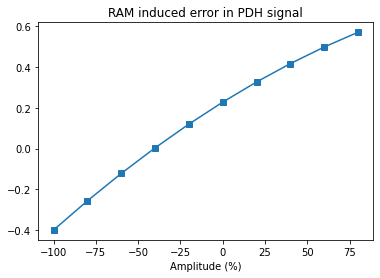

In [118]:
# Alright, now I'm just going to calculate the amplitude of my error signal on resonance as a function of amplitude amplitude (any non-zero value is a RAM-induced error).
det_cav = gamma/2
phase_RAM = -np.pi/2
start_amp = -1
stop_amp = 1
step_amp = 1/5.0
amp_RAM = np.arange(start_amp, stop_amp, step_amp)
PDH_error_RAM = 0*amp_RAM
for i in range(len(amp_RAM)): 
    PDH_error_RAM[i] = np.mean(PDH_RAM(f_N, det_cav, amp_RAM[i], phase_RAM))
plt.figure()
plt.plot(100*amp_RAM,PDH_error_RAM, '-s', label = "calculated")
# Let's compare to the textbook answer
plt.title("RAM induced error in PDH signal")
plt.xlabel("Amplitude (%)")
plt.show()

<ipython-input-117-9eb9dc54ac6e>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  PDH_error_RAM[i] = np.mean(PDH_RAM(f_N, det_cav, amp_RAM, phase_RAM[i]))


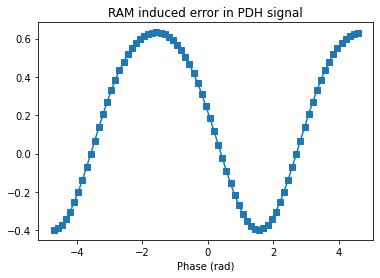

In [117]:
# Alright, now I'm just going to calculate the amplitude of my error signal on resonance as a function of phase (any non-zero value is a RAM-induced error). 
det_cav = gamma/2
amp_RAM = 1
start_phase = -1.5*np.pi
stop_phase = 1.5*np.pi
step_phase = np.pi/25.0
phase_RAM = np.arange(start_phase, stop_phase, step_phase)
PDH_error_RAM = 0*phase_RAM
for i in range(len(phase_RAM)): 
    PDH_error_RAM[i] = np.mean(PDH_RAM(f_N, det_cav, amp_RAM, phase_RAM[i]))
plt.figure()
plt.plot(phase_RAM,PDH_error_RAM, '-s', label = "calculated")
plt.title("RAM induced error in PDH signal")
plt.xlabel("Phase (rad)")
plt.show()

<ipython-input-125-28eb69455842>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  PDH_error_noRAM[i] = np.mean(PDH_RAM(f_N, cav_det[i], 0, 0))
<ipython-input-125-28eb69455842>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  PDH_error_RAM[i] = np.mean(PDH_RAM(f_N, cav_det[i], 0.1, np.pi/2))
<ipython-input-125-28eb69455842>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  PDH_error_RAM2[i] = np.mean(PDH_RAM(f_N, cav_det[i], 0.1, -np.pi/2))


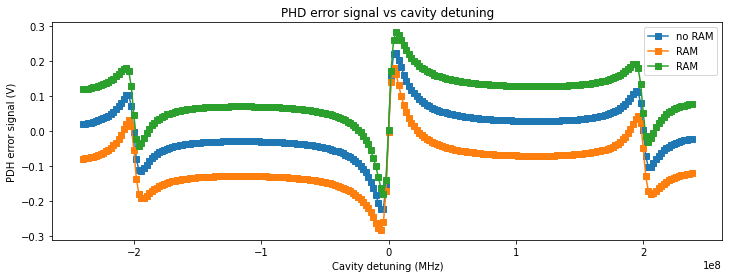

In [125]:
# Let's go back and look at the PDH error signal one should see while scanning across resonance. 
# First, with no RAM, then with some RAM
dt = 1e-11
t_max = 1e-6
t = np.arange(0,t_max,dt) #Timing resolution.
f_0 = 1e9 # This laser is more of a maser.
f_EOM = 200e6 # Frequency of my EOM.
gamma = 10e6 # Cavity linewidth.
cav_det = np.arange(-24*gamma, 24*gamma,0.2*gamma) # Cavity detunings
PDH_error_noRAM = 0*cav_det
for i in range(len(cav_det)):
    PDH_error_noRAM[i] = np.mean(PDH_RAM(f_N, cav_det[i], 0, 0))

PDH_error_RAM = 0*cav_det
for i in range(len(cav_det)):
    PDH_error_RAM[i] = np.mean(PDH_RAM(f_N, cav_det[i], 0.1, np.pi/2))
    

PDH_error_RAM2 = 0*cav_det
for i in range(len(cav_det)):
    PDH_error_RAM2[i] = np.mean(PDH_RAM(f_N, cav_det[i], 0.1, -np.pi/2))
    
plt.figure(figsize = (12,4))
plt.plot(cav_det, PDH_error_noRAM, '-s', label = "no RAM")
plt.plot(cav_det, PDH_error_RAM, '-s', label = "RAM")
plt.plot(cav_det, PDH_error_RAM2, '-s', label = "RAM")
plt.legend()
plt.title("PHD error signal vs cavity detuning")
plt.xlabel("Cavity detuning (MHz)")
plt.ylabel("PDH error signal (V)")
plt.show()